In [1]:
import networkx as nx
from pomps.contextual_graphs import *
from pomps.policy_scope import *
from pomps.controllers import *
import pyro
import torch
import pyro.distributions as dist
from pomps.fcm import *

# from pomis.optimiser import CausalOptimiser, Objective, SCM
from pomis.scm import BoolDomain, SCM

In [2]:
def sampler_over():
    u1 = pyro.sample("U1", dist.Uniform(-1, 1))
    u2 = pyro.sample("U2", dist.Uniform(-1, 1))
    return {"U1": u1, "U2": u2}
fcm = FunctionalCausalModel({Functor(lambda U1, U2: pyro.sample("X", dist.Normal(U1, 0.1)), 'X'),
                             Functor(lambda U1: pyro.sample("Y", dist.Normal(U1, 0.1)), 'Y'),
                             Functor(lambda Y, U2: pyro.sample("Z", dist.Normal(Y, 0.1)), 'Z')}, sampler_over)

def model(count):
    with pyro.plate("samples", count):
        age = pyro.sample("age", dist.Uniform(55, 76))
        bmi = pyro.sample("bmi", dist.Normal(27, 0.7))

        aspirin_p = torch.sigmoid(-8.0 + 0.10 * age + 0.03 * bmi)
        statin_p = torch.sigmoid(-13.0 + 0.10 * age + 0.20 * bmi)

        aspirin = pyro.sample("aspirin", dist.Bernoulli(aspirin_p))
        statin = pyro.sample("statin", dist.Bernoulli(statin_p))

        cancer_p = torch.sigmoid(2.2 - 0.05 * age + 0.01 * bmi - 0.04 * statin + 0.02 * aspirin)
        cancer = pyro.sample("cancer", dist.Bernoulli(cancer_p))

        mean = 6.8 + 0.04 * age - 0.15 * bmi - 0.60 * statin + 0.55 * aspirin + 1.00 * cancer
        y = pyro.sample("y", dist.Normal(mean, 0.4))
    return y
scm = SCM(model, [BoolDomain('aspirin'), BoolDomain('statin')], non_man={'age', 'bmi', 'cancer'})
aspirin_graph = scm.induced_graph()
ccg = ContextualCausalGraph(edges=aspirin_graph, interventional_variables={"aspirin", "statin"}, 
                      contextual_variables={"age", "bmi"}, target='y')

In [4]:
# with pyro.plate('samples', 100_000_000):
#     samples = fcm.sample()

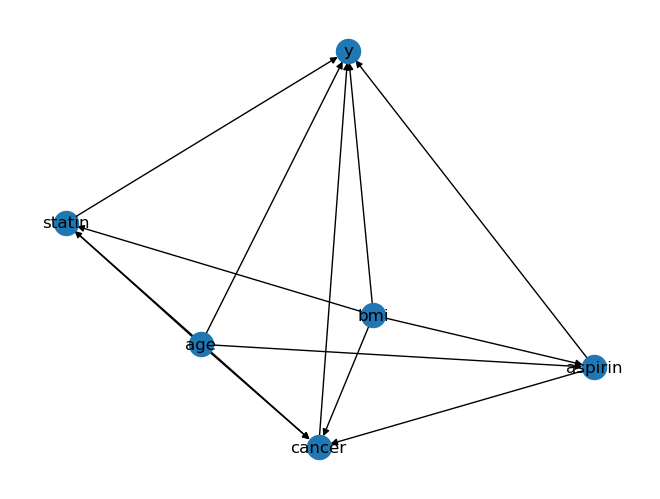

In [5]:
nx.draw(ccg, with_labels=True)

({'aspirin', 'statin'}, {'age', 'bmi'})

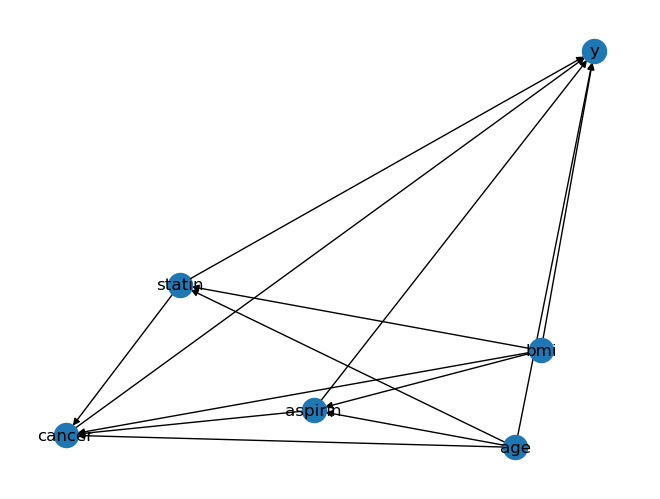

In [10]:
smp_asp = MPSDAGController.simplify(ccg)
nx.draw(smp_asp, with_labels=True)
smp_asp.interventional_variables, smp_asp.contextual_variables

In [6]:
import pandas as pd
pd.DataFrame({'a': [1,2,3], 'b': ['a', 'b', 'c']}).to_dict(orient='records')[0]

{'a': 1, 'b': 'a'}

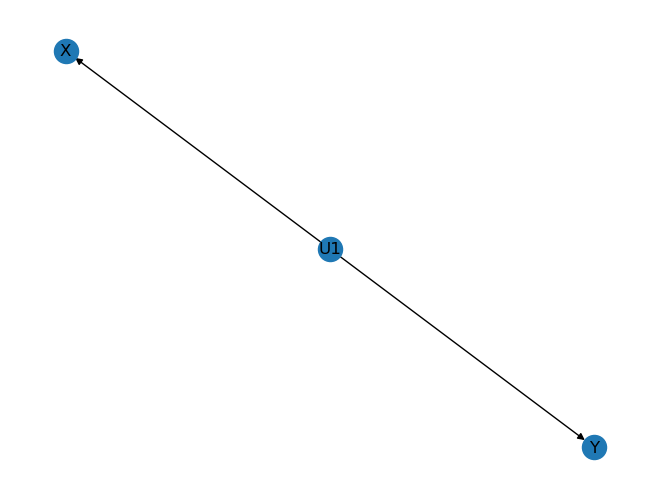

In [12]:
gr = fcm.induced_graph()
gr.contextual_variables = {'Z'}
gr.interventional_variables = {'X'}
sm_gr = MPSDAGController.simplify(gr)
nx.draw(sm_gr, with_labels=True)

In [8]:
sm_gr.contextual_variables, sm_gr.interventional_variables, sm_gr.target, sm_gr.uc_variables

(set(), set(), 'Y', {'U1'})

In [6]:
dr = (nx.DiGraph([('X1', 'X2'), ('C', 'X2'), ('X2', 'Y'), ("U1", "X2"),
                  ("U1", "Y"), ("U2", "X1"), ("U2", "C"), ("C", "Y"), ("U3", "Y")]))
graph = ContextualCausalGraph(edges=dr, uc_variables='auto')
graph.uc_variables

{'U1', 'U2'}

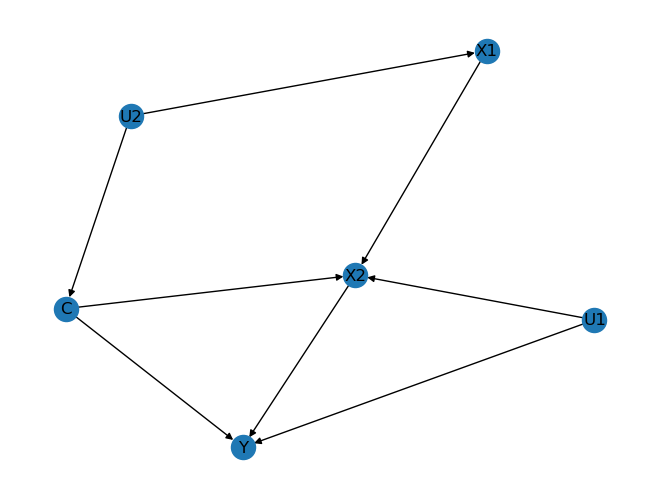

In [9]:
nx.draw(graph, with_labels=True)

In [8]:
mps = MixedPolicyScope([PolicyComponent('X1', {'C'})])
mps_graph, flag = MPSDAGController.graph_under_mps(mps, graph)
assert flag

NetworkXError: The node X1 is not in the digraph.

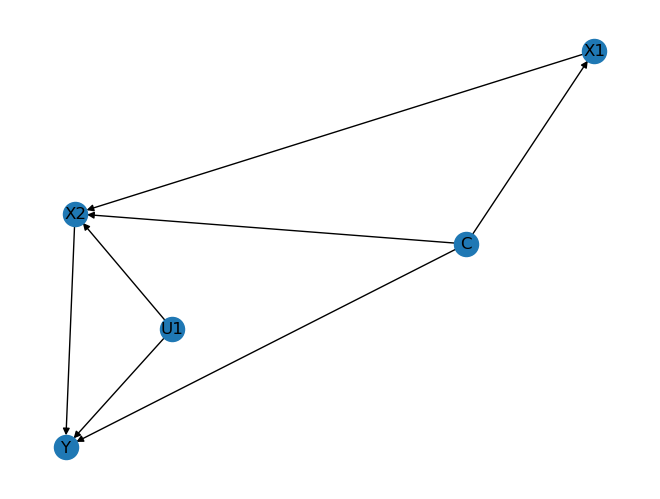

In [5]:
nx.draw(mps_graph, with_labels=True)